In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

data = yf.download("MSFT", start="2019-01-01", end="2025-09-15", auto_adjust=False)["Adj Close"]
data.to_csv("test MSFT.csv")





[*********************100%***********************]  1 of 1 completed


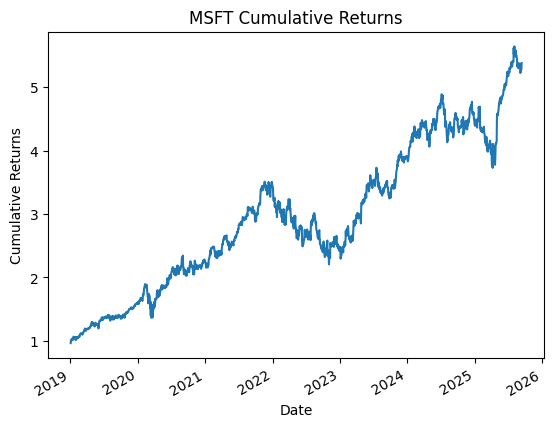

In [12]:
msft=(pd.read_csv("test MSFT.csv", parse_dates=["Date"], index_col="Date")["MSFT"].pct_change()+1).dropna().cumprod()

msft.plot()
plt.ylabel("Cumulative Returns")
plt.title("MSFT Cumulative Returns")
plt.xlabel("Date")
plt.show()

In [2]:
numbers=[2]

for i in range (3,100000,2):
    for j in numbers:
        if i%j==0:
            break
    else:
        numbers.append(i)

print(numbers)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311, 313, 317, 331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397, 401, 409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 467, 479, 487, 491, 499, 503, 509, 521, 523, 541, 547, 557, 563, 569, 571, 577, 587, 593, 599, 601, 607, 613, 617, 619, 631, 641, 643, 647, 653, 659, 661, 673, 677, 683, 691, 701, 709, 719, 727, 733, 739, 743, 751, 757, 761, 769, 773, 787, 797, 809, 811, 821, 823, 827, 829, 839, 853, 857, 859, 863, 877, 881, 883, 887, 907, 911, 919, 929, 937, 941, 947, 953, 967, 971, 977, 983, 991, 997, 1009, 1013, 1019, 1021, 1031, 1033, 1039, 1049, 1051, 1061, 1063, 1069, 1087, 1091, 1093, 1097, 1103, 1109, 1117, 1123, 1129, 1151, 1153, 1163, 1171, 1181, 1187, 1193, 1201, 1213, 1217, 12

In [15]:
def sum_factorials(n):
    total = 0
    for j in range(1, n+1):   
        i = j
        f = 1
        while i >= 1:
            f = f*i
            i = i-1
        total = total + f
    return total

print(sum_factorials(5))


153


In [1]:
def sumfact(n):
    sum = 0
    for i in range(1,n+1): 
        product = 1
        for j in range(1,i+1):
            product *= j
        sum += product
    return sum
print(sumfact(3000))

ValueError: Exceeds the limit (4300 digits) for integer string conversion; use sys.set_int_max_str_digits() to increase the limit

In [25]:
import datetime as dt
import pandas as pd
import yfinance as yf
import numpy as np
from scipy.stats import norm


option_tickers = {
    "SPY": "SPY",
    "USD": "UUP",
    "Gold": "GLD",
    "Crude Oil": "USO",
    "Wheat": "WEAT",
    "Inflation Bond": "TIP",
    "VIX": "^VIX"
}

spot_tickers = {
    "SPY": "SPY",
    "USD": "UUP",
    "Gold": "GC=F",
    "Crude Oil": "CL=F",
    "Wheat": "ZW=F",
    "Inflation Bond": "TIP",
    "VIX": "^VIX"
}

def black_scholes_call(S, K, T, r, sigma):

    #standard black-scholes formula
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call = S * norm.cdf(d1) -  norm.cdf(d2)* K * np.exp(-r * T)
    return call


def vega(S, K, T, r, sigma):

    ### calculating d1 from black scholes
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))

    
    vega = S  * np.sqrt(T) * norm.pdf(d1)
    return vega


def implied_volatility_call(C, S, K, T, r, tol=0.0001, max_iterations=100):

    # assigning initial volatility estimate for input in Newton_rap procedure
    sigma = np.sqrt((2*np.pi)/T)*(C/S)

    for i in range(max_iterations):

        ### calculate difference between blackscholes price and market price with iteratively updated volality estimate
        diff = black_scholes_call(S, K, T, r, sigma) - C

        ###break if difference is less than specified tolerance level
        if abs(diff) < tol:
            break

        ### use newton rapshon to update the estimate
        sigma = sigma - diff / vega(S, K, T, r, sigma)

    return sigma

interest_rate=0.0399 #10 Year Treasury Rate 

def get_options_chain(option_ticker: str) -> pd.DataFrame:

    all_options=[]
    chains = pd.DataFrame

    asset=yf.Ticker(option_ticker)
    expiration_dates=asset.options

    spot = asset.history(period="5d")["Close"].iloc[-1]

    for exp_date in expiration_dates:
        opt=asset.option_chain(exp_date)
        calls=opt.calls

        calls['expiration'] = pd.to_datetime(exp_date) + pd.DateOffset(hours=23, minutes=59, seconds=59)

        calls["TimeToExpiration"] = ((calls["expiration"] - dt.datetime.today()).dt.days + 1)/365
        closest_option_index=(calls['strike']-spot).abs().argmin()
        closest_option=calls.iloc[closest_option_index]
        all_options.append(closest_option)

    chains = pd.DataFrame(all_options)
    chains = chains.set_index('expiration')
    chains['mid']=(chains['ask']+chains['bid'])/2

    chains['implied_volatility'] = chains.apply(lambda row : implied_volatility_call(C=row['mid'], S=spot, K=row['strike'], T=row['TimeToExpiration'], r=interest_rate), axis=1)

    trimmed_chains=chains[['strike', 'bid', 'ask','mid', 'TimeToExpiration', 'implied_volatility']]

    return trimmed_chains

result=get_options_chain("USO")
result

,strike,bid,ask,mid,TimeToExpiration,implied_volatility
expiration,,,,,,
2025-10-29 23:59:59,72.0,0.31,0.36,0.335,0.002740,0.160691
2025-10-31 23:59:59,72.0,0.81,0.86,0.835,0.008219,0.283759
2025-11-05 23:59:59,72.0,1.42,1.47,1.445,0.021918,0.312712
2025-11-07 23:59:59,72.0,1.66,1.73,1.695,0.027397,0.330663
2025-11-14 23:59:59,72.0,2.12,2.20,2.160,0.046575,0.324214
2025-11-21 23:59:59,72.0,2.47,2.55,2.510,0.065753,0.316699
2025-11-28 23:59:59,72.0,2.76,2.85,2.805,0.084932,0.310672
2025-12-05 23:59:59,73.0,2.70,2.80,2.750,0.104110,0.323115
2025-12-19 23:59:59,72.0,3.75,3.95,3.850,0.142466,0.329023


In [ ]:
import plotly.figure_factory as ff
import pandas as pd
from helper import *
import nbformat
from app import *


data = pd.read_csv("data/all_assets_prices.csv", index_col=0, parse_dates=True)

corr_matrix=calc_correlation(data)

heatmap = ff.create_annotated_heatmap(z=corr_matrix.values, 
                                      x=list(corr_matrix.columns), 
                                      y=list(corr_matrix.index), 
                                      annotation_text=corr_matrix.round(2).values, 
                                      showscale=True)
heatmap

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'colorscale': [[0.0, '#0d0887'], [0.1111111111111111, '#46039f'],
                             [0.2222222222222222, '#7201a8'], [0.3333333333333333,
                             '#9c179e'], [0.4444444444444444, '#bd3786'],
                             [0.5555555555555556, '#d8576b'], [0.6666666666666666,
                             '#ed7953'], [0.7777777777777778, '#fb9f3a'],
                             [0.8888888888888888, '#fdca26'], [1.0, '#f0f921']],
              'reversescale': False,
              'showscale': True,
              'type': 'heatmap',
              'x': [SPY, USD, Gold, Crude Oil, Wheat, 10Y T-Bond, Inflation Bond,
                    VIX],
              'y': [SPY, USD, Gold, Crude Oil, Wheat, 10Y T-Bond, Inflation Bond,
                    VIX],
              'z': array([[ 1.        ,  0.78673008,  0.77663881,  0.48564728,  0.24772175,
                           -0.2263271 ,  0.8751697 , -0.08851744],
                          [ 0.78673008,  1.        ,  0.41344722,  0.07578107, -0.15601499,
                           -0.10044619,  0.58157395, -0.1180474 ],
                          [ 0.77663881,  0.41344722,  1.        ,  0.59056016,  0.54673933,
                           -0.38583661,  0.93229209,  0.17236288],
                          [ 0.48564728,  0.07578107,  0.59056016,  1.        ,  0.67518126,
                            0.14708157,  0.49215149,  0.09730015],
                          [ 0.24772175, -0.15601499,  0.54673933,  0.67518126,  1.        ,
                           -0.20287286,  0.45216186,  0.37206403],
                          [-0.2263271 , -0.10044619, -0.38583661,  0.14708157, -0.20287286,
                            1.        , -0.52923113, -0.21390383],
                          [ 0.8751697 ,  0.58157395,  0.93229209,  0.49215149,  0.45216186,
                           -0.52923113,  1.        ,  0.0688242 ],
                          [-0.08851744, -0.1180474 ,  0.17236288,  0.09730015,  0.37206403,
                           -0.21390383,  0.0688242 ,  1.        ]])}],
    'layout': {'annotations': [{'font': {'color': '#000000'},
                                'showarrow': False,
                                'text': '1.0',
                                'x': 'SPY',
                                'xref': 'x',
                                'y': 'SPY',
                                'yref': 'y'},
                               {'font': {'color': '#000000'},
                                'showarrow': False,
                                'text': '0.79',
                                'x': 'USD',
                                'xref': 'x',
                                'y': 'SPY',
                                'yref': 'y'},
                               {'font': {'color': '#000000'},
                                'showarrow': False,
                                'text': '0.78',
                                'x': 'Gold',
                                'xref': 'x',
                                'y': 'SPY',
                                'yref': 'y'},
                               {'font': {'color': '#000000'},
                                'showarrow': False,
                                'text': '0.49',
                                'x': 'Crude Oil',
                                'xref': 'x',
                                'y': 'SPY',
                                'yref': 'y'},
                               {'font': {'color': '#000000'},
                                'showarrow': False,
                                'text': '0.25',
                                'x': 'Wheat',
                                'xref': 'x',
                                'y': 'SPY',
                                'yref': 'y'},
                               {'font': {'color': '#FFFFFF'},
                                'showarrow': False,
                                'text': '-0.23',
                                'x': '10Y T-B

In [10]:
from app import *

mode_data

2025-11-02 19:11:01.750 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-02 19:11:01.751 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-02 19:11:02.010 
  command:

    streamlit run C:\Users\torre\AppData\Roaming\Python\Python313\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-11-02 19:11:02.010 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-02 19:11:02.010 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-02 19:11:02.026 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-02 19:11:02.027 Thread 'MainThread': missing ScriptRunContext! This warning can b

,SPY,Gold
Date,,
2003-12-05,0.000000,0.000000
2003-12-08,0.006716,0.000492
2003-12-09,-0.001029,0.004419
2003-12-10,-0.001123,-0.000492
2003-12-11,0.010058,-0.004439
...,...,...
2025-10-23,2.247294,2.317605
2025-10-24,2.255433,2.315882
2025-10-27,2.267162,2.287187


In [1]:
import pandas_datareader.data as web

yields_data = web.DataReader("IRLTLT01DEM156N", 'fred', "2020-01-01", "2024-06-01")

yields_data

,IRLTLT01DEM156N
DATE,
2020-01-01,-0.313636
2020-02-01,-0.466000
2020-03-01,-0.541364
2020-04-01,-0.449500
2020-05-01,-0.516500
2020-06-01,-0.434286
2020-07-01,-0.523043
2020-08-01,-0.523333
2020-09-01,-0.524091


In [ ]:
cpi_data = web.DataReader('DGS10', 'fred', "2025-11-04", "2025-11-04")

cpi_data

,DGS10
DATE,


In [3]:
import datetime as dt
import pandas_datareader.data as web

end = dt.datetime.today()
start = (end - dt.timedelta(days=5)).strftime("%Y-%m-%d")
end = end.strftime("%Y-%m-%d")
interest_rate=web.DataReader('DGS10', 'fred', start, end).iloc[-1]
interest_rate = interest_rate.iloc[0]
interest_rate


np.float64(4.1)